# Clothing product recommendation using Deep Learning Models in PyTorch

### Context 

Neural networks (NN) are powerful in predicting new customer preferences based on historic data. <br>
NN based recommendation systems have shown to outperform other traditional ML methods. <br>
In this notebook, we will use real world data of clothing sales and customers to make predictions for future customers. <br>
Along with predictions, we will perform Exploratory Data Analysis (EDA) to answer some valuable business questions. <br>

Step 1 - Exploratory Data Analysis (EDA) <br>
Step 2 - Reducing data to tackle class imbalance (CI) and difference in proportion of lables (DPL) <br>
Step 3 - Building Simple feedforward NN to predict future customer preferences <br>
Step 4 - Building Recommednation System using Sparse AutoEncoders (SAE) <br>
Step 5 - Building Recommednation System using Retricted Boltzman Machine (RBM) <br>

### Business Questions 

* Can we recommend similar clothing items to existing customers based on their age groups and past ratings?
* Can we predict which type of clothing a new customer would like and recommend them those to increase our sales?
* Are there specific clothing items or classes that receive consistently positive or negative reviews?
* What are the most popular clothing classes based on the number of reviews?

Age Group Preferences:

* Are there certain age groups that are more likely to rate clothing items positively?
* Do certain age groups tend to give higher or lower ratings?
* Do different age groups prefer different types of clothing?
* Are there certain age groups that consistently recommend specific clothing items?
* Is there a correlation between the age of customers and the ratings they provide?




### Data
* This data has been obtained from Kaggle - https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews
* This dataset includes 23486 rows and 10 feature variables, out of which we will be using following 5 for our use case - 

1. _Clothing ID_: Integer Categorical variable that refers to the specific piece being reviewed.
2. _Age_: Positive Integer variable of the reviewers age.
3. _Rating_: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
4. _Recommended IND_: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
5. _Class Name_: Categorical name of the product class name.


### Methods 
This notebook makes extensive use of Deep Learning expertise learned from the specialization _Deep Learning A-Z_ (PUT GITHUB LINK) <br>
Following methods are used - 
1. **Feedforward Neural Network** - Simple ANN with input + hidden + output layers, forward propagation, no cycle or loop of imformation flow. 
2. **Restricted Boltzman Machine** - Stochastic ANN with visible + hidden layers designed for unsupervised learning, ideal for feature learning and collaborative filtering 
3. **Autoencoders** - ANN designed for unsupervised learning consisting of an encoder and a decoder with the goal to learn a compressed, efficient representation of input data


In [16]:
# Importing required libraries and loading the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import seaborn as sns


In [525]:
df = pd.read_csv('women_clothing.csv',index_col=0)
df = df[['Clothing ID','Age','Rating','Recommended IND','Class Name']]
df.dropna(inplace=True)
df

,Clothing ID,Age,Rating,Recommended IND,Class Name
0,767,33,4,1,Intimates
1,1080,34,5,1,Dresses
2,1077,60,3,0,Dresses
3,1049,50,5,1,Pants
4,847,47,5,1,Blouses
...,...,...,...,...,...
23481,1104,34,5,1,Dresses
23482,862,48,3,1,Knits
23483,1104,31,3,0,Dresses
23484,1084,28,3,1,Dresses


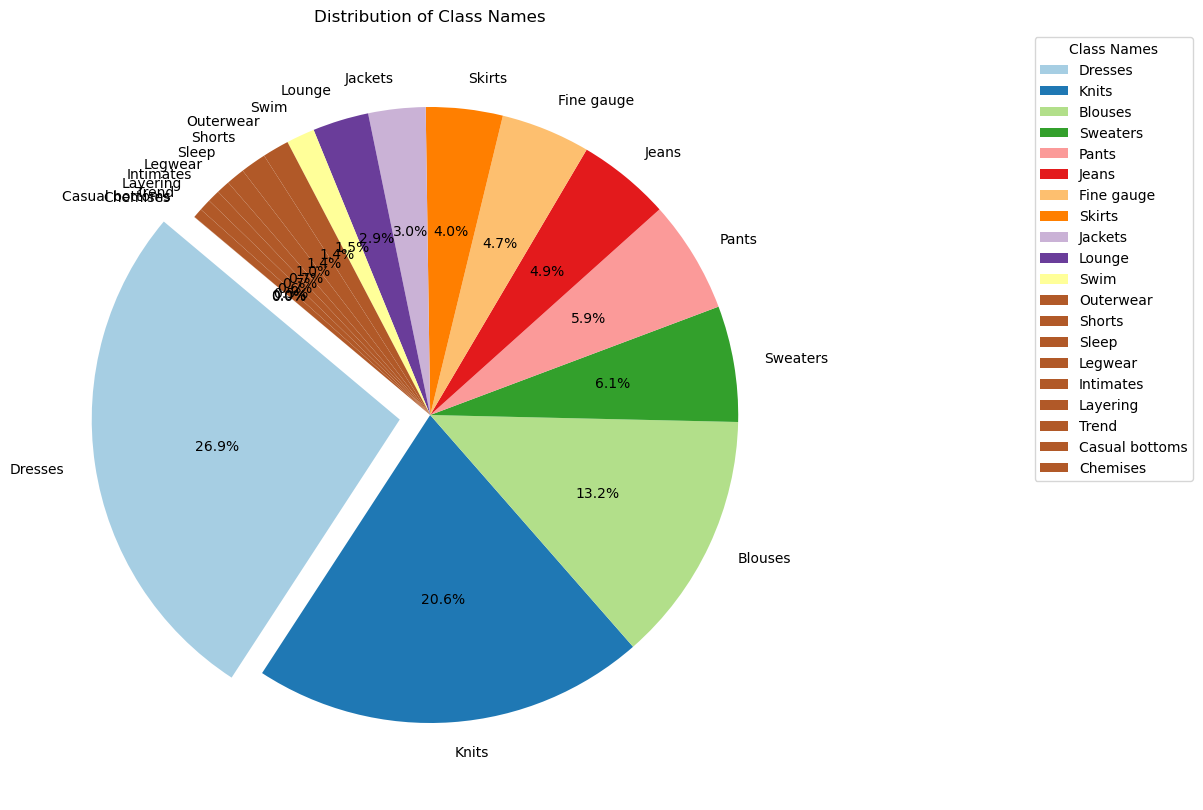

In [526]:
# Creating a pie chart to see the distribution of 'Class Name' 

# Count the occurrences of each class name
class_counts = df['Class Name'].value_counts()

# Define colors
colors = plt.cm.Paired(range(len(class_counts)))

# Explode the first slice
explode = (0.1,) + tuple(0 for _ in range(len(class_counts) - 1))

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Distribution of Class Names')
plt.legend(title='Class Names', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


### NOTE - 
Clearly, our dataset is _imbalanced_. Two things that need to be corrected here before any analyis  - 
1. **Class Imbalance** - some classes are significantly less/more represented in the data than the other (here outwear/shorts/swim and dresses/knits 
2. **Difference in Proportion of labels** (we will see this later) - The distribution of ratings (1 - 5) across different classes 

* Dealing with class imbalance is important in machine learning, as models trained on imbalanced datasets may exhibit biased behavior toward the majority class.
* Various techniques, such as oversampling the minority class, undersampling the majority class, or using synthetic data generation, can be employed to address class imbalance and improve model performance.

In [527]:
# identifying classes with <1% values and removing those 

# Calculate the percentage of each class
class_percentages = class_counts / len(df) * 100

# Identify column names with less than 1% data points
columns_with_less_than_1_percent = class_percentages[class_percentages < 1].index

print(columns_with_less_than_1_percent.to_list())

df = df[~df['Class Name'].isin(columns_with_less_than_1_percent)]

df

['Sleep', 'Legwear', 'Intimates', 'Layering', 'Trend', 'Casual bottoms', 'Chemises']


,Clothing ID,Age,Rating,Recommended IND,Class Name
1,1080,34,5,1,Dresses
2,1077,60,3,0,Dresses
3,1049,50,5,1,Pants
4,847,47,5,1,Blouses
5,1080,49,2,0,Dresses
...,...,...,...,...,...
23481,1104,34,5,1,Dresses
23482,862,48,3,1,Knits
23483,1104,31,3,0,Dresses
23484,1084,28,3,1,Dresses


In [663]:
# Now sampling the data to handle Class Imbalance (CI) 

# Filter ratings to include only those in the range 0-5
df_filtered = df[df['Rating'].between(0, 5)]

# Create an empty dataframe to store balanced samples
balanced_df = pd.DataFrame()

# Set the desired number of samples for each class and rating
desired_samples = 40

# Iterate through each combination of 'Class Name' and 'Rating'
for class_name, group in df_filtered.groupby(['Class Name', 'Rating']):
    # Sample the desired number of rows for each combination
    sampled_rows = group.sample(min(len(group), desired_samples), random_state=42)
    # Concatenate the sampled rows to the balanced dataframe
    balanced_df = pd.concat([balanced_df, sampled_rows])

# Optional: Shuffle the rows in the resulting dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the balanced dataframe
balanced_df

,Clothing ID,Age,Rating,Recommended IND,Class Name
0,1044,24,4,1,Pants
1,1056,34,5,1,Pants
2,869,29,4,1,Knits
3,999,36,5,1,Skirts
4,1093,47,4,1,Dresses
...,...,...,...,...,...
2379,1046,47,4,1,Pants
2380,868,35,4,1,Knits
2381,863,65,4,1,Knits
2382,194,39,4,1,Lounge


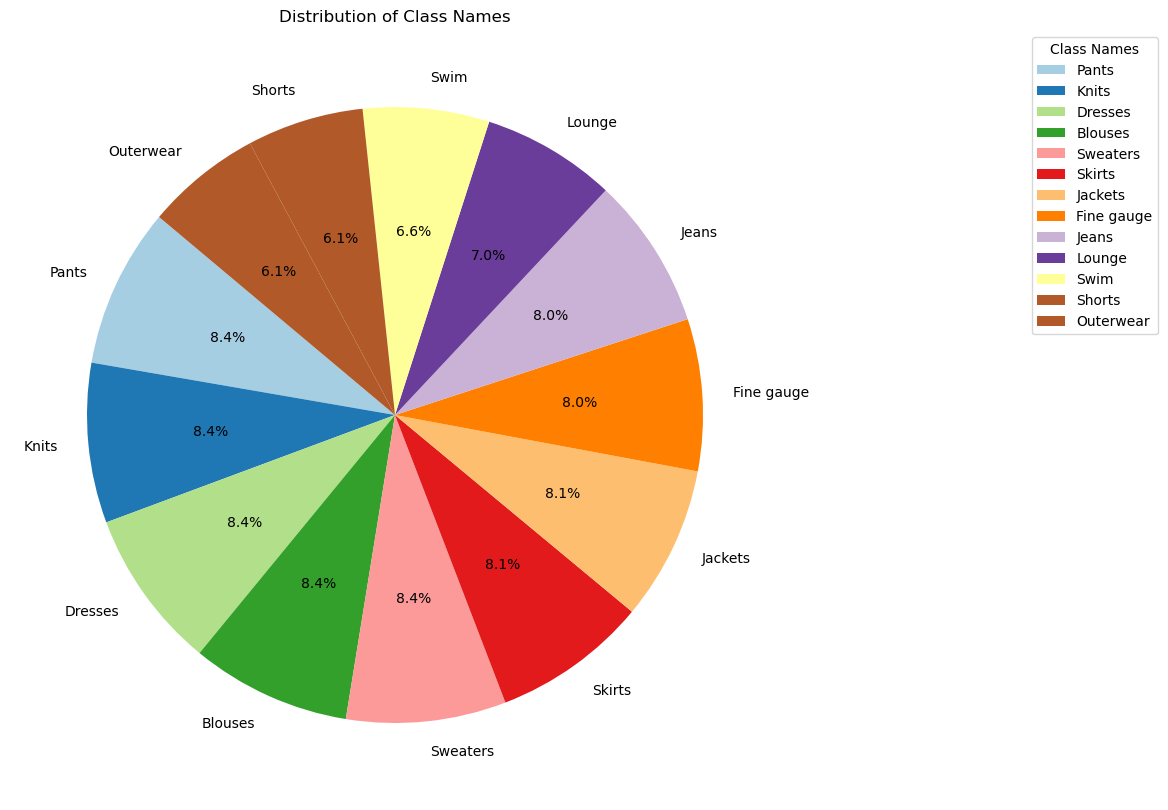

In [664]:
# Creating a pie chart on BALANCED data to see the distribution of 'Class Name' 

# Count the occurrences of each class name
class_counts = balanced_df['Class Name'].value_counts()

# Define colors
colors = plt.cm.Paired(range(len(class_counts)))

# Explode the first slice
explode = (0.1,) + tuple(0 for _ in range(len(class_counts) - 1))

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Class Names')
plt.legend(title='Class Names', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


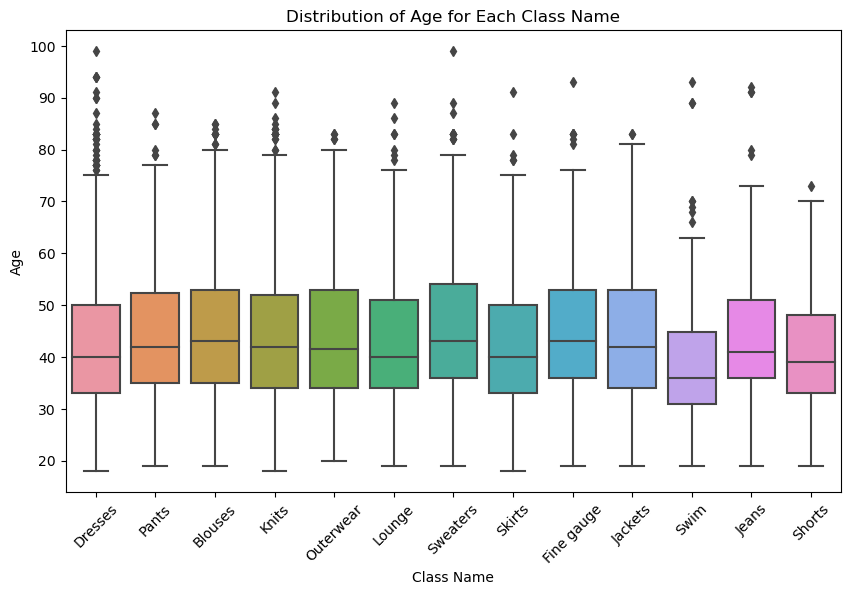

In [665]:
# Creating a Boxplot to see the 'Age' distributions for each Class Name (IMBALANCED data) 

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class Name', y='Age', data=df)
plt.xticks(rotation=45)
plt.title('Distribution of Age for Each Class Name')
plt.show()

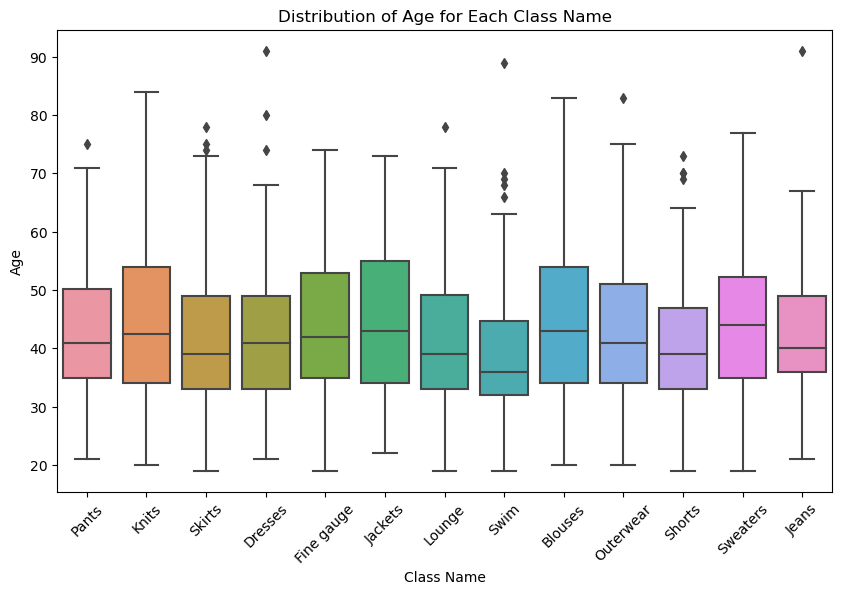

In [666]:
# Creating a Boxplot to see the 'Age' distributions for each Class Name (BALANCED data) 

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class Name', y='Age', data=balanced_df)
plt.xticks(rotation=45)
plt.title('Distribution of Age for Each Class Name')
plt.show()

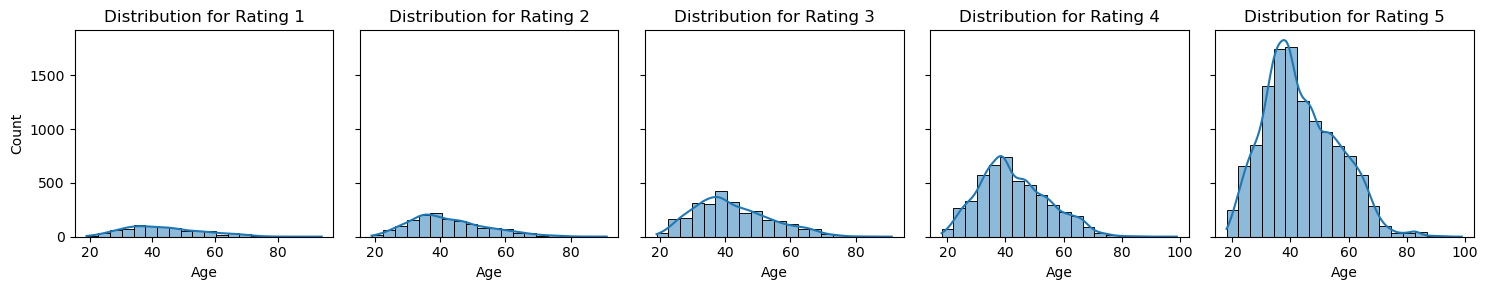

In [667]:
# Distribution of 'Ages' for each rating (IMBALANCED data)

fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

# Iterate over each rating (1 to 5) and create a distribution plot
for rating in range(1, 6):
    ax = axes[rating - 1]
    sns.histplot(df[df['Rating'] == rating]['Age'], bins=20, kde=True, ax=ax)
    ax.set_title(f'Distribution for Rating {rating}')
    ax.set_xlabel('Age')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

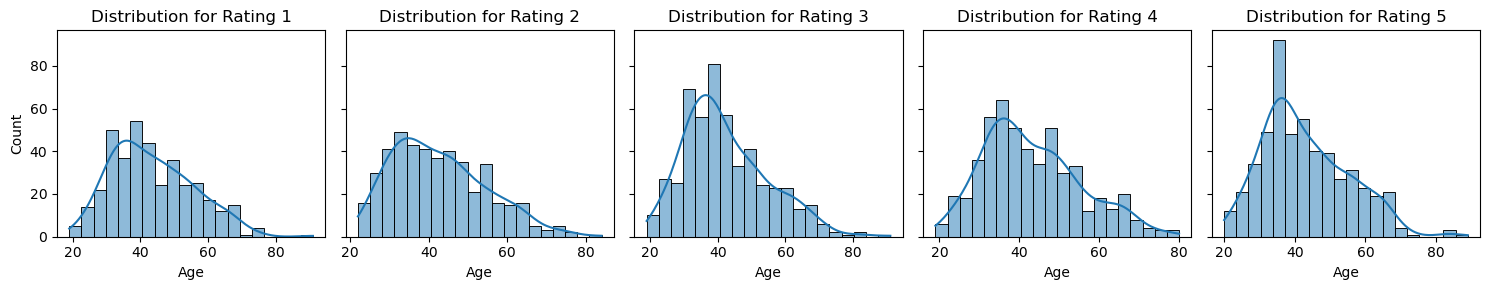

In [668]:
# Distribution of Ages for each rating (BALANCED data)

fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

# Iterate over each rating (1 to 5) and create a distribution plot
for rating in range(1, 6):
    ax = axes[rating - 1]
    sns.histplot(balanced_df[balanced_df['Rating'] == rating]['Age'], bins=20, kde=True, ax=ax)
    ax.set_title(f'Distribution for Rating {rating}')
    ax.set_xlabel('Age')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

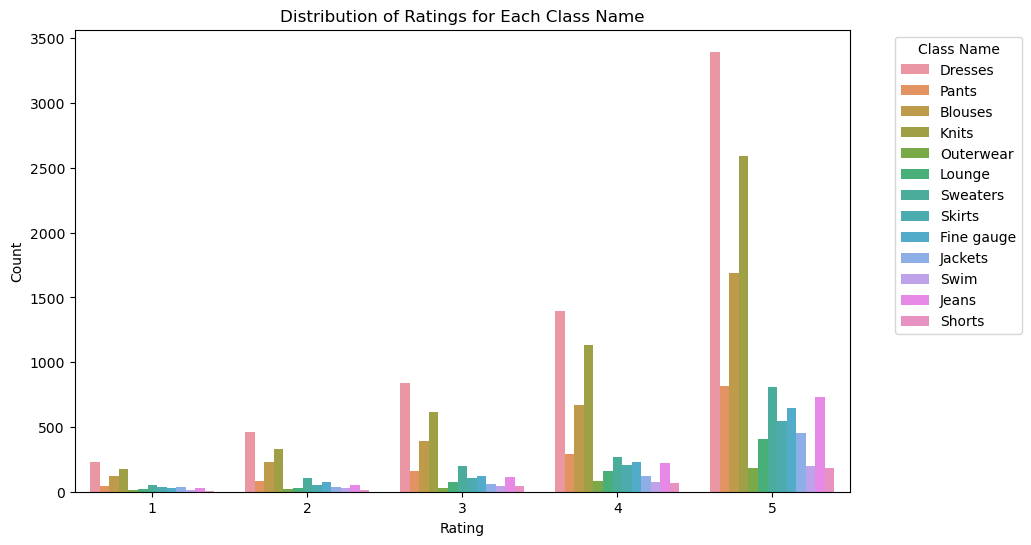

In [669]:
# Histogram distributions of 'Rating' for various Class Names (IMBALANCED data) 

plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', hue='Class Name', data=df)
plt.title('Distribution of Ratings for Each Class Name')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Class Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


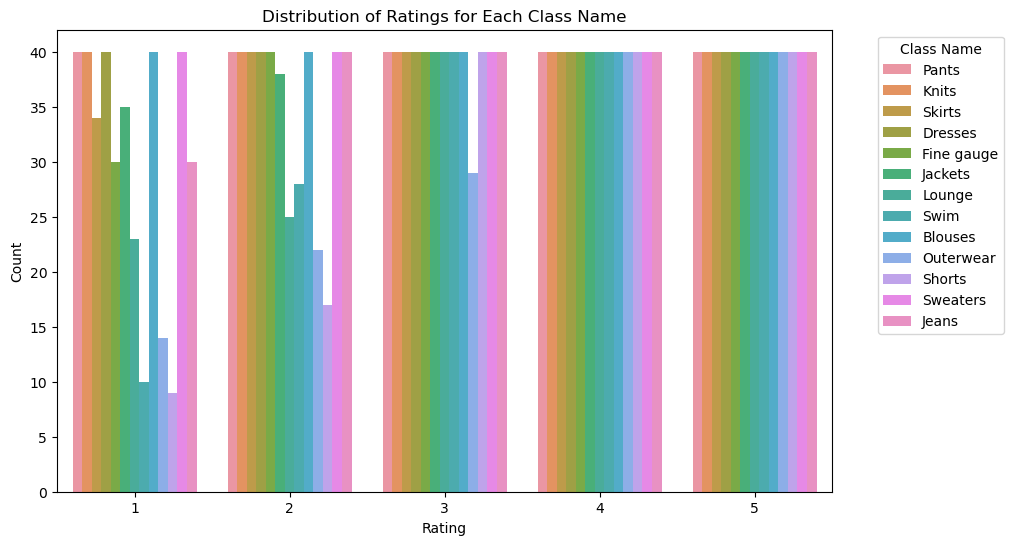

In [670]:
# Histogram distributions of 'Rating' for various Class Names (BALANCED data) 

plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', hue='Class Name', data=balanced_df)
plt.title('Distribution of Ratings for Each Class Name')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Class Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


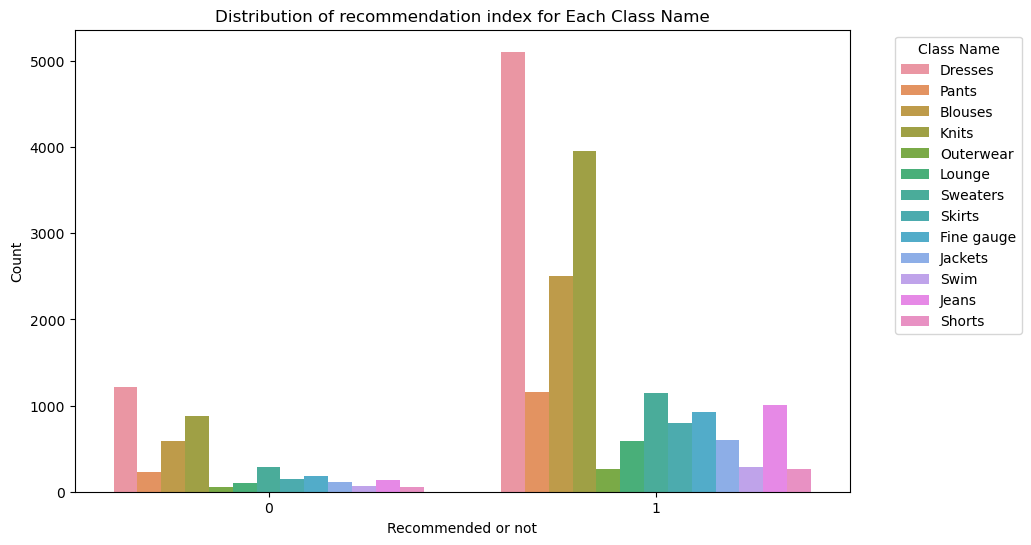

In [671]:
# Histogram distributions of 'Recommendation Index' for various Class Names (IMBALANCED data) 

plt.figure(figsize=(10, 6))
sns.countplot(x='Recommended IND', hue='Class Name', data=df)
plt.title('Distribution of recommendation index for Each Class Name')
plt.xlabel('Recommended or not')
plt.ylabel('Count')
plt.legend(title='Class Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


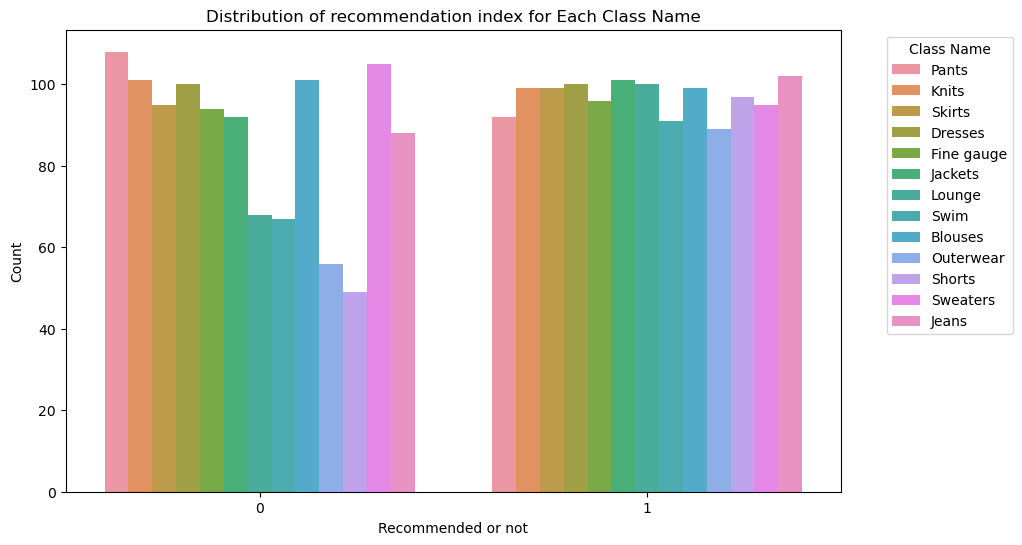

In [672]:
# Histogram distributions of 'Recommendation Index' for various Class Names (BALANCED data) 

plt.figure(figsize=(10, 6))
sns.countplot(x='Recommended IND', hue='Class Name', data=balanced_df)
plt.title('Distribution of recommendation index for Each Class Name')
plt.xlabel('Recommended or not')
plt.ylabel('Count')
plt.legend(title='Class Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### **NOTE** - 

As the minority class instances are less, we chose [desired_samples = 40] for **all classes** to account for the imbalance. <br>
This could be further improved with - 
1. More data from minority classes leading to higher sample size.
2. Reducing _desired_samples_ even further to match the sample size, which might not be optimal to train an ML model  

### **MODEL-1**
Building _Basic_ Feedforward Neural Network with [Clothing ID, Age, Class Name] data to predict [Rating] for a new customer <br>
It has 1 input, 3 hidden and 1 output fully connected layers <br> 
ReLU activation function used after each hidden layer <br> 
Training using MSE loss and L2 regularization  <br>

In [721]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch.nn.functional as F

# Data Preprocessing
X = df[['Clothing ID', 'Age', 'Class Name']]
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature transformation pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age']),
        ('cat', OneHotEncoder(), ['Class Name'])
    ])

# Build the neural network

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Instantiate the model
input_size = 14
model = NeuralNetwork(input_size)

# L2 regularization strength
lambda_reg = 0.07

# Loss function and optimizer with L2 regularization
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.3, weight_decay=lambda_reg)

# Training the model
epochs = 200
for epoch in range(epochs):
    inputs = Variable(torch.Tensor(preprocessor.fit_transform(X_train).toarray()))
    targets = Variable(torch.Tensor(y_train.values.reshape(-1, 1)))

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # L2 regularization
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)

    loss += lambda_reg * l2_reg

    loss.backward()
    optimizer.step()

# Evaluate the model
with torch.no_grad():
    test_inputs = Variable(torch.Tensor(preprocessor.transform(X_test).toarray()))
    predictions = model(test_inputs)

# Calculate evaluation metrics as needed
test_loss = criterion(predictions, Variable(torch.Tensor(y_test.values.reshape(-1, 1))))
print('Test Loss:', test_loss.item())


Test Loss: 1.2851377725601196


Great! Our simple Neural Network is decgreatent at predicting a customer's POTENTIAL CHOICES (ratings) _if we give age and clothing details to it_ <br>
**Test loss of 1.28 implies that the predictions would be off by ~1 on average for a new customer. <br>**
However, we would like to automate this process. <br>
Let's build a recommendation system based on AGE GROUPS <br>
**Given age group of a new customer, what are all the clothings they would like?** 

## Recommendation System 

### MODEL-2
Building Sparse Auto Encoder (SAE) using [Clothing ID, Age, Rating] data to recommend clothing to new customers

### Data Preprocessing
We will be needing data in a particular format - **rows** representing **age groups**, **columns** representing unique **clothing IDs** and values in the dataframe representing the **median ratings** from that age group for that clothing <br>
Using _pivot_ function for that

In [504]:
from sklearn.model_selection import train_test_split

bins = range(18, 100, 5)  # Creates bins from 18 to 99, 5 units apart
labels = [f'{i}-{i+4}' for i in range(18, 95, 5)]  # Label for each bin

# Create a new column for age groups
balanced_df['Age Group'] = pd.cut(balanced_df['Age'], bins=bins, labels=labels, right=True)

# Split the dataset into train and test
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Group by Age Group and Clothing ID on the train set
grouped_train = train_df.groupby(['Age Group', 'Clothing ID'])['Rating'].median().reset_index()

# Pivot the table on the train set
pivot_train_df = grouped_train.pivot(index='Age Group', columns='Clothing ID', values='Rating')

# Perform similar operations on the test set
grouped_test = test_df.groupby(['Age Group', 'Clothing ID'])['Rating'].median().reset_index()
pivot_test_df = grouped_test.pivot(index='Age Group', columns='Clothing ID', values='Rating')

pivot_train_df.fillna(0,inplace=True)
pivot_test_df.fillna(0,inplace=True)

In [505]:
df1 = pd.DataFrame(pivot_train_df)
df1

Clothing ID,7,8,11,18,24,31,36,47,62,63,...,1169,1170,1175,1176,1177,1180,1185,1189,1193,1195
Age Group,,,,,,,,,,,,,,,,,,,,,
18-22,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23-27,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28-32,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,3.0,...,0.0,0.0,3.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0
33-37,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38-42,5.0,5.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0
43-47,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48-52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53-57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
58-62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [506]:
df2 = pd.DataFrame(pivot_test_df)
df2

Clothing ID,24,75,80,94,110,119,167,190,191,192,...,1121,1122,1123,1125,1126,1127,1134,1167,1171,1192
Age Group,,,,,,,,,,,,,,,,,,,,,
18-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23-27,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28-32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,5.0,0.0
33-37,5.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,3.0,0.0,...,0.0,4.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,5.0
38-42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0
43-47,0.0,0.0,2.0,0.0,0.0,4.0,0.0,3.0,0.0,2.0,...,0.0,1.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0
48-52,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0
53-57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
58-62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### NOTE - 
The shape of the train and test set is different (more columns in train) <br>
This is because there is more data and hence more unique clothing IDs in train set <br>
We **need same dimensions for both train and test set** - rows representing all unique age groups and columns depicting all unique clothing IDs <br>
Adding missing clothing IDs to both train and test set with 0 values (indicating no rating available) <br>

In [508]:
missing_columns =  set(df2.columns) - set(df1.columns)
for column in missing_columns:
    df1[column] = np.nan
    
# Sorting the columns
columns_to_sort = [col for col in df1.columns if col != 'Clothing ID']
sorted_columns = sorted(columns_to_sort, key=lambda x: int(x))

# Reconstruct DataFrame with 'Clothing ID' as the first column
df1[sorted_columns]

# Replacing NaN with 0s
df1.fillna(0,inplace=True)

df1 = df1.sort_index(axis=1)
df1

Clothing ID,7,8,11,18,24,31,36,47,62,63,...,1171,1175,1176,1177,1180,1185,1189,1192,1193,1195
Age Group,,,,,,,,,,,,,,,,,,,,,
18-22,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23-27,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28-32,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,3.0,...,0.0,3.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0
33-37,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38-42,5.0,5.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0
43-47,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48-52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53-57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
58-62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [509]:
missing_columns = set(df1.columns) - set(df2.columns)
for column in missing_columns:
    df2[column] = np.nan
    
# Sorting the columns
columns_to_sort = [col for col in df2.columns if col != 'Clothing ID']
sorted_columns = sorted(columns_to_sort, key=lambda x: int(x))

# Reconstruct DataFrame with 'Clothing ID' as the first column
df2[sorted_columns]

# Replacing NaN with 0s
df2.fillna(0,inplace=True)

df2 = df2.sort_index(axis=1)
df2

/Users/yashakaushal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


Clothing ID,7,8,11,18,24,31,36,47,62,63,...,1171,1175,1176,1177,1180,1185,1189,1192,1193,1195
Age Group,,,,,,,,,,,,,,,,,,,,,
18-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28-32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33-37,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
38-42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43-47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48-52,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53-57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58-62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [510]:
train_set = df1.values.tolist()
test_set = df2.values.tolist()

In [729]:
### Converting list of lists to torch tensors 

train_set = torch.FloatTensor(train_set)
test_set = torch.FloatTensor(test_set)

### Creating the architecture of Sparse Auto Encoder (SAE) Neural Network

In [512]:
nb_age_groups = train_set.shape[0]
nb_clothings = train_set.shape[1]

In [535]:
# Blueprint of the network we want to create , contains variables and functions(methods), definitions of layers + activation + optimization
# All functions in one recipe - 'class' ! 
# Will use inheritence - create a class 'SAE' which is child class of an existing parent class 'Module' in Pytorch 
# Why? to be able to use all variables + functions of a parent class 
# Will optimize it using 'super' function 

class SAE(nn.Module): # 
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_clothings, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_clothings)
        self.activation = nn.Sigmoid() # for 3 layers
    def forward(self, x): # do 2 encoding and 2 decoding and apply activation functions, will return vector of predicted ratings (that we will compare with real ratings)
        x = self.activation(self.fc1(x)) # x is ratings of all movies by a user A
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x) # no activation required here, nb_movies dimensions decoded 
        return x
sae = SAE() # object of SAE class
criterion = nn.MSELoss() # criterion for loss function 
optimizer = optim.RMSprop(sae.parameters(), lr = 0.001, weight_decay = 0.8) # to save computation memory for >1 million row large data

# The weight_decay parameter controls the strength of L2 regularization. 
# It adds a term to the optimization objective, penalizing large weights in the model. 
# This helps prevent overfitting by discouraging the model from relying too much on any single feature.


### Training the SAE

In [536]:
# Age-group vs all clothing data 

nb_epoch = 200
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0. # keeping track of users that did at least 1 rating, used in last step after loop 
  for age_group in range(nb_age_groups):
    
    # keras/pytorch do not accept vector of 1 dimension, need to add a fake dimension, 0 is index of new dimension
    # here creating a batch of input vector, 
    input = Variable(train_set[age_group]).unsqueeze(0) 
    
    # copy of input as we will be modifying the input later on 
    target = input.clone()
    
    if torch.sum(target.data > 0) > 0: # to save memory, only looking at the users who rated at least 1 movie, removing input with all 0s
      output = sae(input)
      target.require_grad = False # make sure the stochastic gradient descent is calculated wrt i/p and not target, saves a lot of memory - optimization
      output[target == 0] = 0 # these values don't count in updating the error + saves memory  
      loss = criterion(output, target) # prediction and truth to get loss 
      # as we adopted only clothings with non-zero ratings (or moveis that were seen by the user), need to correct for that 
      mean_corrector = nb_clothings/float(torch.sum(target.data > 0) + 1e-10) # total/only that were +vely rated 
      loss.backward() # increase/decrease the weight? - backward method makes sure it is done properly - decides direction of increment/decrement of weights
      train_loss += np.sqrt(loss.data*mean_corrector) # updated for every user in each batch 
      s += 1.
      optimizer.step() # decides intensity of the update , .step() implements it on optimizer object 
  print('epoch: '+str(epoch)+'loss: '+ str(train_loss/s))

epoch: 1loss: tensor(3.4267)
epoch: 2loss: tensor(3.2669)
epoch: 3loss: tensor(3.0620)
epoch: 4loss: tensor(2.8190)
epoch: 5loss: tensor(2.5386)
epoch: 6loss: tensor(2.2263)
epoch: 7loss: tensor(1.9209)
epoch: 8loss: tensor(1.6830)
epoch: 9loss: tensor(1.5402)
epoch: 10loss: tensor(1.4588)
epoch: 11loss: tensor(1.3983)
epoch: 12loss: tensor(1.3386)
epoch: 13loss: tensor(1.2733)
epoch: 14loss: tensor(1.2053)
epoch: 15loss: tensor(1.1422)
epoch: 16loss: tensor(1.0917)
epoch: 17loss: tensor(1.0536)
epoch: 18loss: tensor(1.0233)
epoch: 19loss: tensor(0.9976)
epoch: 20loss: tensor(0.9747)
epoch: 21loss: tensor(0.9536)
epoch: 22loss: tensor(0.9341)
epoch: 23loss: tensor(0.9165)
epoch: 24loss: tensor(0.9015)
epoch: 25loss: tensor(0.8898)
epoch: 26loss: tensor(0.8817)
epoch: 27loss: tensor(0.8767)
epoch: 28loss: tensor(0.8735)
epoch: 29loss: tensor(0.8706)
epoch: 30loss: tensor(0.8674)
epoch: 31loss: tensor(0.8639)
epoch: 32loss: tensor(0.8606)
epoch: 33loss: tensor(0.8577)
epoch: 34loss: tens

### Testing the SAE 

In [537]:
test_loss = 0
s = 0.
for age_group in range(nb_age_groups):
  input = Variable(train_set[age_group]).unsqueeze(0) # training set 
  target = Variable(test_set[age_group]).unsqueeze(0) # test set with truth values 
  if torch.sum(target.data > 0) > 0:
    output = sae(input)
    target.require_grad = False
    output[target == 0] = 0
    loss = criterion(output, target) # only for training not test 
    mean_corrector = nb_clothings/float(torch.sum(target.data > 0) + 1e-10)
    test_loss += np.sqrt(loss.data*mean_corrector)
    s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(1.5521)


Okay our _SAE Recommendation System_ performed decently in predicting new customer's likes and dislikes. <br>
Test loss of 1.5 still suggests that we are close to predicting what they really want <br>
Let's see if we get any improvement in predictions with _Boltzmann Machine_

### MODEL - 3
Building a Restricted Boltzman Machine (RBM) Recommendation System using [Clothing ID, Age, Rating] data to recommend clothing to new customers

### Data Preprocessing 
We will be using same train and test set as we obtained for SAE <br> 
We will further convert the ratings in binary format - 1 (like) and 0 (dislike) 

In [744]:
train_set[(train_set>0) & (train_set<=1)] = 0
train_set[(train_set>1) & (train_set<=2)] = 0
train_set[(train_set>2) & (train_set<3)] = 0
train_set[(train_set>=3) & (train_set<=5)] = 1

test_set[(test_set>0) & (test_set<=1)] = 0
test_set[(test_set>1) & (test_set<=2)] = 0
test_set[(test_set>2) & (test_set<3)] = 0
test_set[(test_set>=3) & (test_set<=5)] = 1


### Creating architecture of RBM

In [755]:
# 1 class 3 functions 

class RBM():
    
  def __init__(self, nv, nh): # defines parameters of the object that will be created from this class , mandatory. 
    # self - object that is created afterwards, number of visible nodes (nv), number of hidden nodes (nh)
    
    self.W = torch.randn(nh, nv) # initializes a tensor of size (nh,nv) according to a normal distribution - mean 0, variance 1 
    # initializing bias - prob of v given h and vice versa 
    self.a = torch.randn(1, nh) # ph_given_v - 2D vector probabilities
    self.b = torch.randn(1, nv) # pv_given_h - 2D
    
    # now sampling the activations of the hidden nodes - activate each hidden node according to a certain probability (prob that n_h = 1 given v)
  def sample_h(self, x): # takes 2 arguments, self and x : vector of visible neurons v i.e. ratings 
    wx = torch.mm(x, self.W.t()) #.mm matrix multiplication and .t() is transpose 
    activation = wx + self.a.expand_as(wx) # wx + bias = wx + a (need to make sure bias is added to each line of mini-batch, using expand_as 
    # this below represents probability that hidden node is activated acc to the visible nodes
    p_h_given_v = torch.sigmoid(activation) # 
    return p_h_given_v, torch.bernoulli(p_h_given_v) # return probabilities and samples of hidden neurons which is a vector of 0s and 1s (if random # </> p_h_given_v)

    # same for visible nodes - need to predict probabilities for movies that user did not originally rated
  def sample_v(self, y): # y - vector of hidden neurons
    wy = torch.mm(y, self.W) #no transpose needed
    activation = wy + self.b.expand_as(wy)
    p_v_given_h = torch.sigmoid(activation)
    return p_v_given_h, torch.bernoulli(p_v_given_h)

    # contrastive divergence to calc approx log-likelihood gradients - using gibbs sampling 
    # goal is to minimize energy and maximize log likelihood -> need to compute gradient for that -> precise are too computationally heavy -> approximate it 
    # in the direction of decreasing energy -> instead of MCMC from RBM distribution, gibbs chain for k-steps is sufficient -> sample visible/hidden/visible ....
    # here we update our tensor of weights W, bias a and bias b 
    # v0 - input vector (all ratings by one user), vk - visible nodes obtained after k (round trip) samplings 
    # ph0 - vector of probabilities that initially hidden nodes =1 given the values of v0, phk - vector of probabilities of hidden nodes =1 after k samplings given vk
  def train(self, v0, vk, ph0, phk):
    self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
    self.b += torch.sum((v0 - vk), 0) # to maintain dimension of b as 2-D
    self.a += torch.sum((ph0 - phk), 0)
    
    
nv = len(train_set[0]) # no of movies 
nh = 10 # we choose, no of features that could be detected from the sample (actor, director etc) 
batch_size = 1 # if 1 update nn after each observation feeding in or after every 100 observations 
rbm = RBM(nv, nh)

In [756]:
nb_age_groups = train_set.shape[0]
nb_clothings = train_set.shape[1]

### Training RBM

In [757]:
# using the class we created 
# calculate loss with each epoch - RMSE/mean absolute error MAE  - to measure error need loss function  


nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0. # need a counter to normalize train loss
  for age_group in range(0, nb_age_groups - batch_size, batch_size): #taking batches of users 
    vk = train_set[age_group : age_group + batch_size]
    v0 = train_set[age_group : age_group + batch_size]
    ph0,_ = rbm.sample_h(v0)
    for k in range(10): # k steps for contrastive divergence 
      _,hk = rbm.sample_h(vk)
      _,vk = rbm.sample_v(hk) # after 1st sampling of hidden nodes, vk updates in each step 
      vk[v0<0] = v0[v0<0] # we don't wanna learn cells with no info / -1 ratings, keeping -1 in every loop so no training happens on these values 
    phk,_ = rbm.sample_h(vk) # from the last sample of visible node after gibbs sampling
    rbm.train(v0, vk, ph0, phk)
    train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0])) # difference in predicted and actual ratings of all movies for each batch of users
    s += 1.
  print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))


epoch: 1 loss: tensor(0.1255)
epoch: 2 loss: tensor(0.0017)
epoch: 3 loss: tensor(0.0016)
epoch: 4 loss: tensor(0.0009)
epoch: 5 loss: tensor(0.0007)
epoch: 6 loss: tensor(0.0003)
epoch: 7 loss: tensor(0.0010)
epoch: 8 loss: tensor(0.0002)
epoch: 9 loss: tensor(0.0006)
epoch: 10 loss: tensor(0.0003)


In [758]:
test_loss = 0
s = 0.
for age_group in range(nb_age_groups):
    v = train_set[age_group:age_group+1] # getting predictions of test set from training set - activating neurons of RBM using training data 
    vt = test_set[age_group:age_group+1] # true target values of the test set 
    if len(vt[vt>=0]) > 0: # removing -1 ratings, 
        _,h = rbm.sample_h(v) # remove k, no k steps 
        _,v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.0421)


### VOILA! 
* The test accuracy of RBM is much better better than SAE! **(test loss: 0.0421 << 1.5521)** 
* Note that we further simplified _Rating_ here to binary format - 1 (like) and 0 (dislike) 

### Recap 

* We performed EDA on clothing data to see the distributions of various features
* We converted imbalanced data into balanced data for predictive analysis
* We trained **3** neural network models to predict new customer behavior 
    1. Basic Neural Network : 
        - Trained it on _exact_ age of previous customers, clothing ID and clothing type to predict the rating a new customer would give
        - Test loss of **1.2851**
        - This model could be improved with more customer data (income, zipcode,) 
        - NLP techniques could on review text could also empower this.
    2. Sparse Auto Encoder (SAE) Recommendation System 
        - Modified the data to have median ratings in age groups of 5 years each ranging from (18 yr - 99 yr) for each clothing item
        - Trained 80% data using SAE to predict the rating for a new customer in a given age group 
        - Test loss of **1.5521** 
        - This model has shown less accuracy then expected, could be improved with more features and data
    3. Restricted Boltzmann Machine (RBM) Recommendation System 
        - Same data modification and goal as in SAE
        - We simplified the ratings as YES/1 (Rating: 3,4,5) and No/0 (Rating: 1,2) 
        - Test accuracy of **0.0421** is remarkable 
        - Could be made more powerful with incorporating text and other numerical data from customers
        